In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [111]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
nan_cols = test.isna().sum()
test1 = test.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)
train1 = train.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)

In [112]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# fit and transform the data
test_imputed = pd.DataFrame(imputer.fit_transform(test1), columns=test1.columns)
train_imputed = pd.DataFrame(imputer.fit_transform(train1), columns=train1.columns)

#### Removing null correlation columns

In [118]:
corr_matrix = train_imputed.corr().abs()

corr_y = train_imputed.corrwith(train_imputed['y'])
train_clean = train_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1)
test_clean = test_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1)

#### Removing high correlation columns

In [113]:
# identify predictors that have correlation of > 0.85
indices = np.where(np.triu(corr_matrix > 0.85, k=1))

# print the pairs of columns that have a correlation > 0.85
high_corr = []
count = 0
for idx in range(len(indices[0])):
    col1 = corr_matrix.columns[indices[0][idx]]
    col2 = corr_matrix.columns[indices[1][idx]]
    high_corr.append(col1)
    count+=1
    #print(f"{col1} and {col2}")
#print(count)

unique_vals = set(high_corr)
train_clean = train_clean.drop(unique_vals, axis = 1)

test_col = train_clean.drop('y', axis = 1)
test_clean = test_clean[test_col.columns]

In [114]:
test_clean.shape

(4403, 224)

#### Removing low correlation with y columns

In [116]:
corr_matrix = train_clean.corr().abs()

corr_y = train_clean.corrwith(train_clean['y'])

low_corr_cols = corr_y[corr_y < 0.01].index.tolist() # 0.01 was best so far 

In [96]:
len(low_corr_cols)

22

In [97]:
train_clean = train_clean.drop(low_corr_cols, axis = 1)
test_col = train_clean.drop('y', axis = 1)
test_clean = train_clean[test_col.columns]

### Feature Importances

In [123]:
model = Earth(max_terms=500, max_degree=1, feature_importance_type ='rss') 
model.fit(train_clean,y)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(feature_importance_type='rss', max_degree=1, max_terms=500)

In [124]:
predictor = pd.Series(train_clean.columns, name = 'predictor')
rel_importance = pd.Series(model.feature_importances_, name = 'relative importance')
importance = pd.concat([predictor, rel_importance], axis = 1).sort_values(by = 'relative importance', ascending = False)

In [125]:
importance

,predictor,relative importance
0,id,0.0
474,x501,0.0
476,x503,0.0
477,x504,0.0
478,x505,0.0
...,...,...
242,x253,0.0
243,x254,0.0
244,x256,0.0
245,x257,0.0


### Scaling data

In [98]:
X = train_imputed.drop('y', axis = 1)
y = train_imputed.y

In [99]:
X_test = test_imputed

In [100]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

In [101]:
X_scaled.shape

(5380, 37)

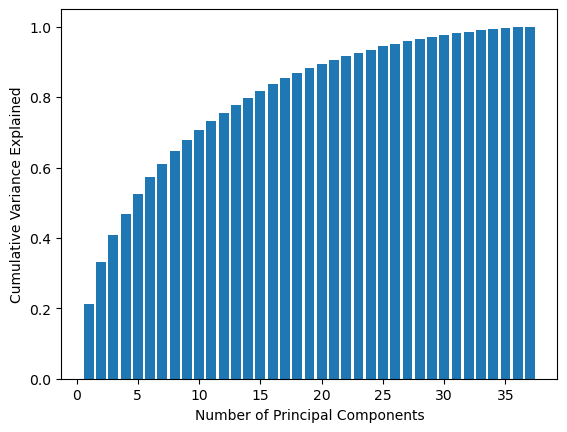

In [102]:
from sklearn.decomposition import PCA
plt.rcParams.update(plt.rcParamsDefault)
pca = PCA()
pca.fit(X_scaled)

# Get the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratios
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the cumulative sum of the explained variance ratios against the number of principal components
plt.bar(range(1, pca.n_components_ + 1), cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [103]:
pca = PCA(n_components = 0.99)
pca.fit(X_scaled)

PCA(n_components=0.99)

In [104]:
X_train_pca = pca.transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [105]:
#Finding the lasso coefficients for increasing values of the tuning parameter
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

alphas = 10**np.linspace(10,-2,100)*0.1
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_pca, y)
    coefs.append(lasso.coef_)

In [106]:
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(X_train_pca, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.013063376127816646

In [107]:
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(X_train_pca, y)

Lasso(alpha=0.013063376127816646)

In [108]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = lasso.predict(X_test_pca)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') ## RMSE: 9.674